**This notebook is from the Handson Machine Learning using Scikit Learn and Tensorflow, 2nd edition**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Time Series Prediction using RNNs

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

2023-04-03 01:15:01.610290: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-03 01:15:01.641691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 01:15:03.037917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-03 01:15:05.944904: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

# Basic RNNs

## Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


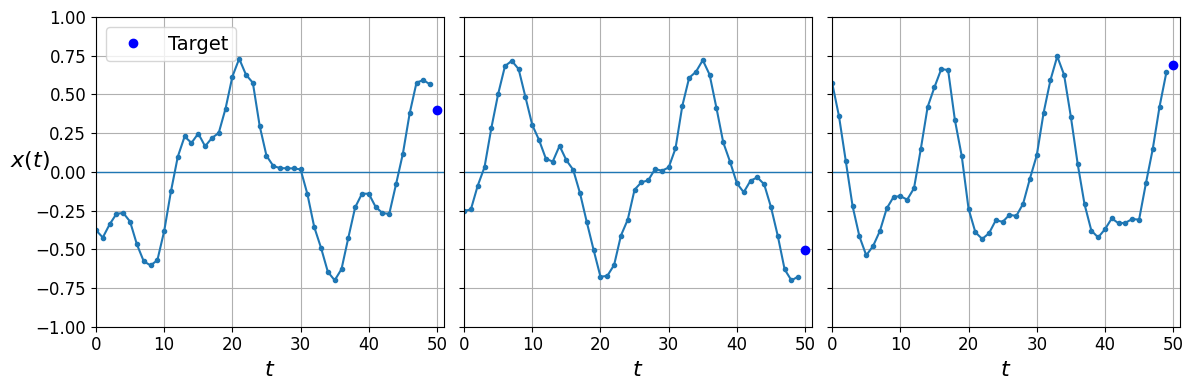

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

**Note**: in this notebook, the blue dots represent targets, and red crosses represent predictions. In the book, I first used blue crosses for targets and red dots for predictions, then I reversed this later in the chapter. Sorry if this caused some confusion.

## Computing Some Baselines

Naive predictions (just predict the last observed value):

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

2023-04-03 01:15:07.230039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-03 01:15:07.230238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-03 01:15:07.230340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

0.020211367

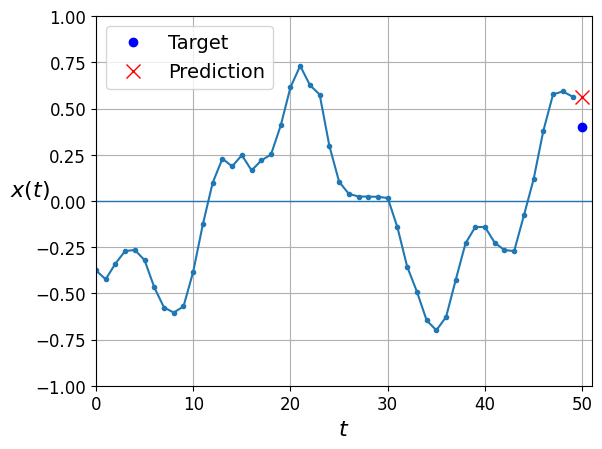

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])
optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.2138 - val_loss: 0.0607
Epoch 2/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0353 - val_loss: 0.0217
Epoch 3/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0136
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0120 - val_loss: 0.0105
Epoch 5/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0097 - val_loss: 0.0090
Epoch 6/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0063 - val_loss: 0.0062

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 959us/step - loss: 0.0043


0.0042771766893565655

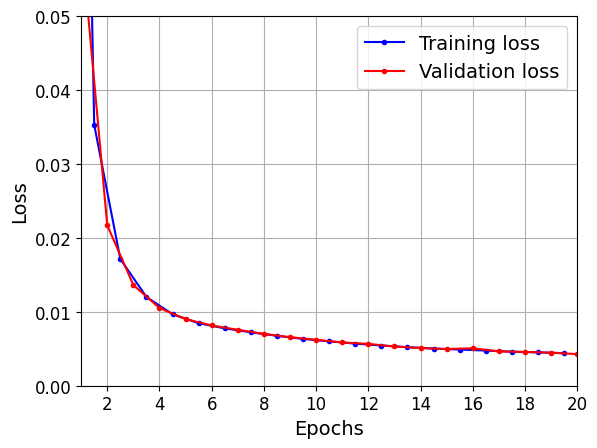

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 701us/step


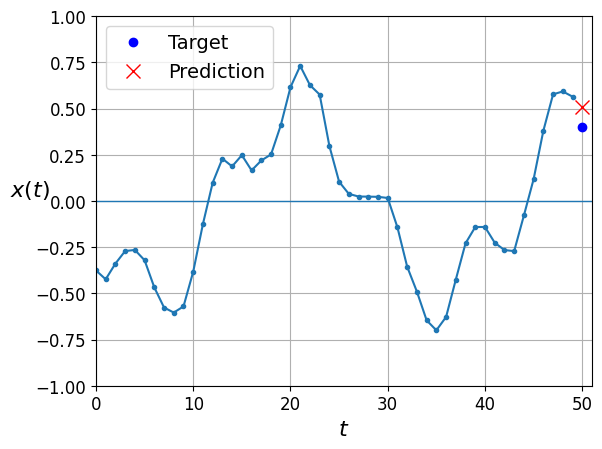

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Using a Simple RNN

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)


In [13]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 13ms/step - loss: 0.3467 - val_loss: 0.2507
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.1673 - val_loss: 0.1192
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0749 - val_loss: 0.0462
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0285 - val_loss: 0.0183
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0142 - val_loss: 0.0120
Epoch 6/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 7/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 9/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 10/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0114 - val_lo

In [14]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0109


0.010874304920434952

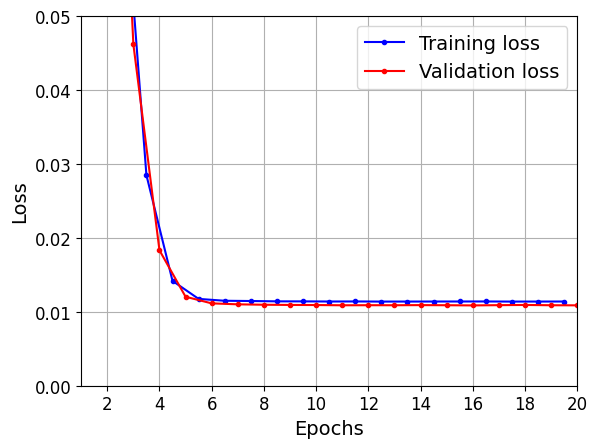

In [15]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 5ms/step


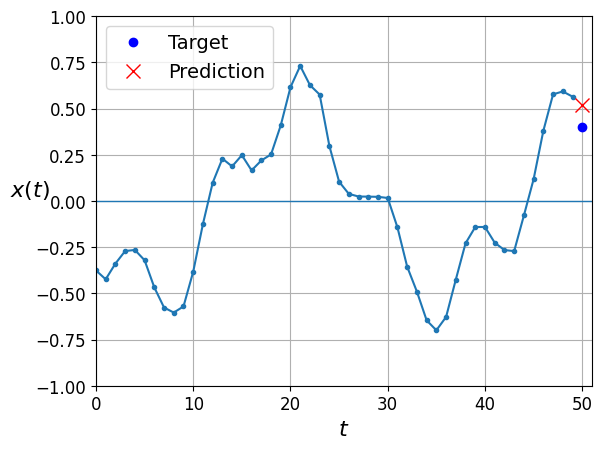

In [16]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
  5/219 [..............................] - ETA: 7s - loss: 0.6929 

2023-04-03 01:16:18.206168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


219/219 [==============================] - 9s 38ms/step - loss: 0.0586 - val_loss: 0.0075
Epoch 2/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0064 - val_loss: 0.0054
Epoch 3/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 4/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 6/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 7/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 8/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 9/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 10/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0033 - val_loss: 0.0033

In [18]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 12ms/step - loss: 0.0030


0.0029970561154186726

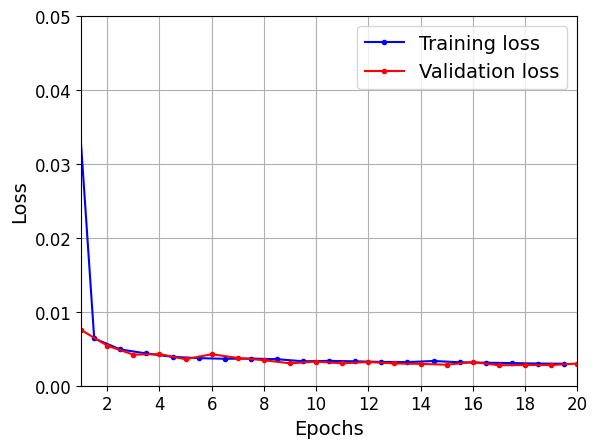

In [19]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 11ms/step


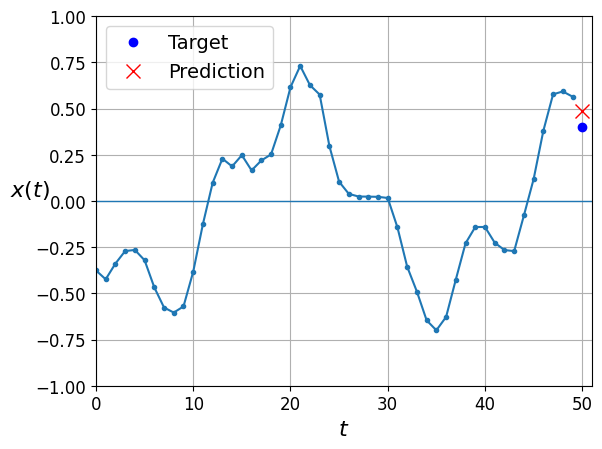

In [20]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 27ms/step - loss: 0.0158 - val_loss: 0.0043
Epoch 2/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 3/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 4/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 5/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 6/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 8/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 9/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0028 - val_lo

In [22]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0026


0.0025967753026634455

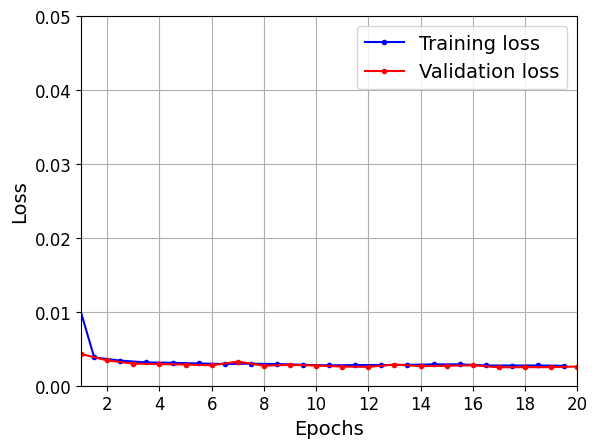

In [23]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 8ms/step


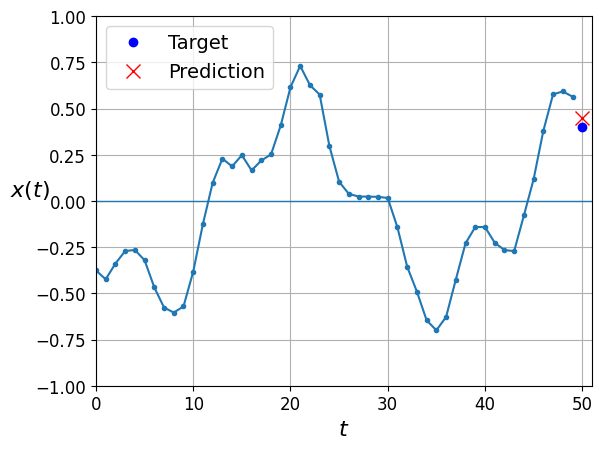

In [24]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [25]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 17ms/step


In [26]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


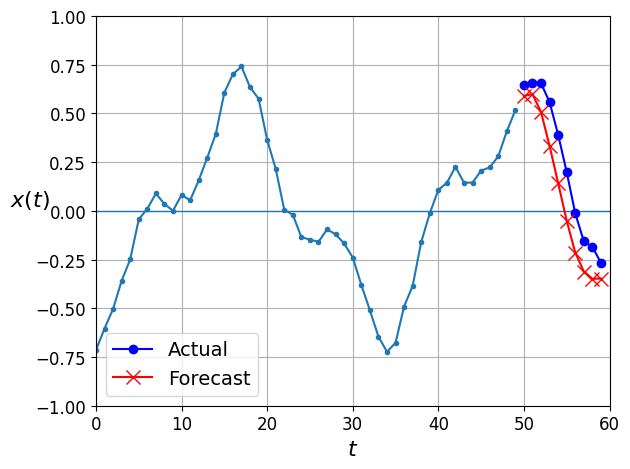

In [27]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [28]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [29]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 0s 7ms/step


In [30]:
Y_pred.shape

(2000, 10)

In [31]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.021999795

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [32]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1268 - val_loss: 0.0661
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0440
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0359
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0317
Epoch 5/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0303 - val_loss: 0.0290
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0280 - val_loss: 0.0272
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0264 - val_loss: 0.0257
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0252 - val_loss: 0.0245
Epoch 9/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0242 - val_loss: 0.0238
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0234 - val_loss: 0.0230

Now let's create an RNN that predicts all 10 next values at once:

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0560 - val_loss: 0.0310
Epoch 2/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0257 - val_loss: 0.0186
Epoch 3/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0177 - val_loss: 0.0151
Epoch 4/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0150 - val_loss: 0.0132
Epoch 5/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0129 - val_loss: 0.0116
Epoch 6/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0118 - val_loss: 0.0108
Epoch 7/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 8/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 9/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0101 - val_loss: 0.0101
Epoch 10/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0098 - val_lo

In [35]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 121ms/step


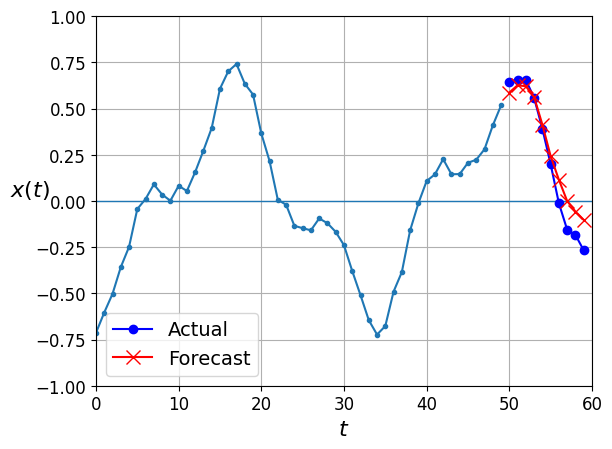

In [36]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [37]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [38]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [39]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.legacy.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 29ms/step - loss: 0.0500 - last_time_step_mse: 0.0393 - val_loss: 0.0417 - val_last_time_step_mse: 0.0307
Epoch 2/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0362 - last_time_step_mse: 0.0243 - val_loss: 0.0353 - val_last_time_step_mse: 0.0252
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0298 - last_time_step_mse: 0.0182 - val_loss: 0.0281 - val_last_time_step_mse: 0.0174
Epoch 4/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0260 - last_time_step_mse: 0.0137 - val_loss: 0.0234 - val_last_time_step_mse: 0.0107
Epoch 5/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0235 - last_time_step_mse: 0.0108 - val_loss: 0.0221 - val_last_time_step_mse: 0.0097
Epoch 6/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0225 - last_time_step_mse: 0.0102 - val_loss: 0.0207 - val_last_time_step_mse: 0.0079
Epoch 7/20
219/219 [==

In [40]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 129ms/step


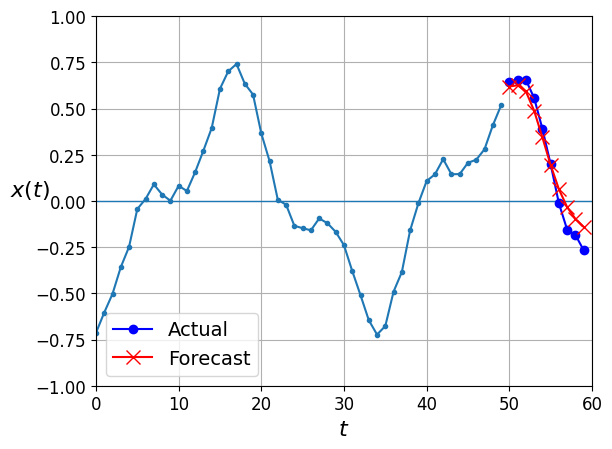

In [41]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Deep RNN with Batch Norm

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 29ms/step - loss: 0.1563 - last_time_step_mse: 0.1382 - val_loss: 0.1005 - val_last_time_step_mse: 0.0948
Epoch 2/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0515 - last_time_step_mse: 0.0411 - val_loss: 0.0498 - val_last_time_step_mse: 0.0398
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0445 - last_time_step_mse: 0.0339 - val_loss: 0.0425 - val_last_time_step_mse: 0.0315
Epoch 4/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0409 - last_time_step_mse: 0.0297 - val_loss: 0.0399 - val_last_time_step_mse: 0.0282
Epoch 5/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0377 - last_time_step_mse: 0.0258 - val_loss: 0.0361 - val_last_time_step_mse: 0.0240
Epoch 6/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0350 - last_time_step_mse: 0.0221 - val_loss: 0.0346 - val_last_time_step_mse: 0.0203
Epoch 7/20
219/219 [==

# Deep RNNs with Layer Norm

In [43]:
#from tensorflow.keras.layers import LayerNormalization
from keras.layers import LayerNormalization

In [44]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [45]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
  3/219 [..............................] - ETA: 9s - loss: 0.5561 - last_time_step_mse: 0.5485  

2023-04-03 01:27:52.486722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


219/219 [==============================] - 15s 63ms/step - loss: 0.1271 - last_time_step_mse: 0.1131 - val_loss: 0.0640 - val_last_time_step_mse: 0.0521
Epoch 2/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0566 - last_time_step_mse: 0.0445 - val_loss: 0.0505 - val_last_time_step_mse: 0.0386
Epoch 3/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0467 - last_time_step_mse: 0.0355 - val_loss: 0.0434 - val_last_time_step_mse: 0.0324
Epoch 4/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0407 - last_time_step_mse: 0.0296 - val_loss: 0.0378 - val_last_time_step_mse: 0.0251
Epoch 5/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0360 - last_time_step_mse: 0.0230 - val_loss: 0.0338 - val_last_time_step_mse: 0.0192
Epoch 6/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0331 - last_time_step_mse: 0.0196 - val_loss: 0.0320 - val_last_time_step_mse: 0.0180
Epoch 7/20
219/219 [=======

# Creating a Custom RNN Class

In [46]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


2023-04-03 01:32:16.046251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,?,1]
	 [[{{node Placeholder}}]]
2023-04-03 01:32:16.132142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,?,20]
	 [[{{node Placeholder}}]]


219/219 [==============================] - 16s 69ms/step - loss: 0.1704 - last_time_step_mse: 0.1578 - val_loss: 0.0834 - val_last_time_step_mse: 0.0751
Epoch 2/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0652 - last_time_step_mse: 0.0531 - val_loss: 0.0572 - val_last_time_step_mse: 0.0447
Epoch 3/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0538 - last_time_step_mse: 0.0426 - val_loss: 0.0499 - val_last_time_step_mse: 0.0377
Epoch 4/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0477 - last_time_step_mse: 0.0371 - val_loss: 0.0453 - val_last_time_step_mse: 0.0339
Epoch 5/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0439 - last_time_step_mse: 0.0334 - val_loss: 0.0417 - val_last_time_step_mse: 0.0304
Epoch 6/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0409 - last_time_step_mse: 0.0306 - val_loss: 0.0392 - val_last_time_step_mse: 0.0288
Epoch 7/20
219/219 [=======

# LSTMs

In [48]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

optimizer=tf.keras.optimizers.legacy.Adam()

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


2023-04-03 01:37:12.254896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-03 01:37:12.255902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-03 01:37:12.256584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

219/219 [==============================] - ETA: 0s - loss: 0.0758 - last_time_step_mse: 0.0613

2023-04-03 01:37:15.847494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-03 01:37:15.848582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-03 01:37:15.849500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

219/219 [==============================] - 4s 11ms/step - loss: 0.0758 - last_time_step_mse: 0.0613 - val_loss: 0.0531 - val_last_time_step_mse: 0.0332
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0467 - last_time_step_mse: 0.0267 - val_loss: 0.0415 - val_last_time_step_mse: 0.0200
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0385 - last_time_step_mse: 0.0180 - val_loss: 0.0371 - val_last_time_step_mse: 0.0175
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0346 - last_time_step_mse: 0.0149 - val_loss: 0.0330 - val_last_time_step_mse: 0.0139
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0321 - last_time_step_mse: 0.0134 - val_loss: 0.0311 - val_last_time_step_mse: 0.0130
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0303 - last_time_step_mse: 0.0124 - val_loss: 0.0291 - val_last_time_step_mse: 0.0116
Epoch 7/20
219/219 [================

In [49]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0230 - last_time_step_mse: 0.0085


[0.023015474900603294, 0.008515006862580776]

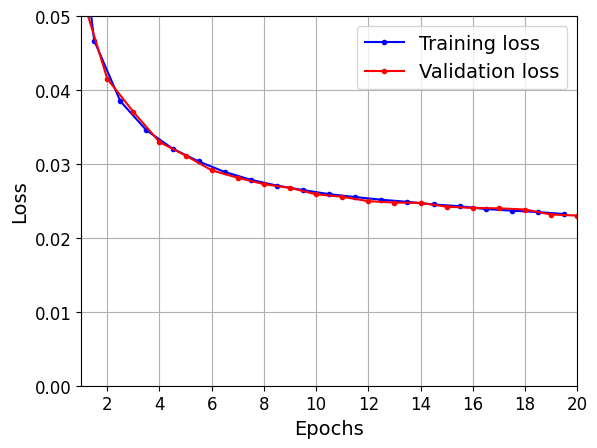

In [50]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [51]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

2023-04-03 01:37:52.916896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-03 01:37:52.917818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-03 01:37:52.918825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 320ms/step


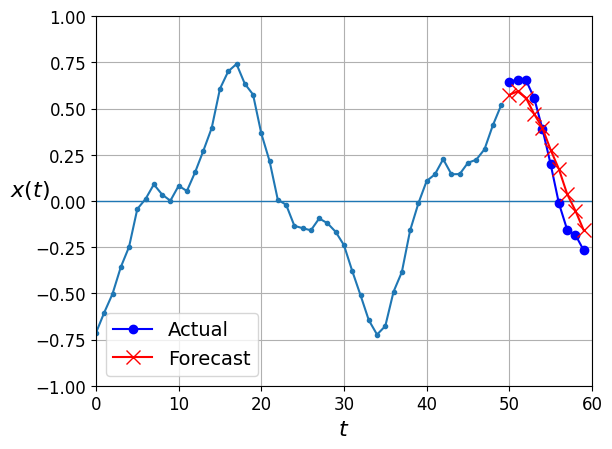

In [52]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()